# Data Download

In [3]:
import os
import pathlib
import requests
import xmltodict

def download_data(S3_BUCKET_URL="http://arxiv-nlp-5years.s3-us-west-1.amazonaws.com", DATA_DIR="./data"):
    r = requests.get(S3_BUCKET_URL)  # Get bucket contents
    xml_data = xmltodict.parse(r.text)  # XML listing of bucket contents
    num_files = len(xml_data["ListBucketResult"]["Contents"])

    DATA_DIR_PATH = pathlib.Path(DATA_DIR)
    DATA_DIR_PATH.mkdir(exist_ok=True, parents=True)
    (DATA_DIR_PATH/"raw").mkdir(exist_ok=True, parents=True)
    (DATA_DIR_PATH/"preprocessed").mkdir(exist_ok=True, parents=True)
    (DATA_DIR_PATH/"features").mkdir(exist_ok=True, parents=True)

    # Iterate over files and download each one to raw
    for i, file in enumerate(xml_data["ListBucketResult"]["Contents"]):
        fp = file["Key"]
        print(f"{i+1}/{num_files} - Downloading {fp}")
        with open(DATA_DIR_PATH/"raw"/fp, "wb") as write_fp:
            write_fp.write(requests.get(os.path.join(S3_BUCKET_URL, fp)).content)

In [4]:
DATA_DIR = "./data"
download_data(DATA_DIR=DATA_DIR)

1/9 - Downloading arXiv_metadata_000000000000.json
2/9 - Downloading arXiv_metadata_000000000001.json
3/9 - Downloading arXiv_metadata_000000000002.json
4/9 - Downloading arXiv_metadata_000000000003.json
5/9 - Downloading arXiv_metadata_000000000004.json
6/9 - Downloading arXiv_metadata_000000000005.json
7/9 - Downloading arXiv_metadata_000000000006.json
8/9 - Downloading arXiv_metadata_000000000007.json
9/9 - Downloading arXiv_metadata_000000000008.json


# Imports and setup

In [5]:
# Dask import
import dask.delayed
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import LocalCluster, Client
from dask_ml.model_selection import GridSearchCV

# Other utility imports
import os
import sys
import re
import glob
import json
import string
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from itertools import cycle
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score

In [6]:
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44491 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 10 Memory: 13.63 GB


In [7]:
DATA_DIR_PATH = pathlib.Path("./data")
raw_data_dir = DATA_DIR_PATH/"raw"
preproc_data_dir = DATA_DIR_PATH/"preprocessed"
feature_data_dir = DATA_DIR_PATH/"features"

json_glob_pattern = "arXiv_metadata_*.json"

# Complete category list
category_list = ["Computer Science", "Mathematics", "Physics", "Quantitative Biology",
                                  "Quantitative Finance", "Statistics", "Economics",
                                  "Electrical Engineering and Systems Science"]

# Preprocessing

## Exploring the data

In [8]:
raw_df = pd.read_json(raw_data_dir/"arXiv_metadata_000000000000.json", orient='index')
raw_df.head()

,abstract,authors,categories,journal-ref,title
0704.0005,In this paper we show how to compute the $\Lam...,"{'author': [{'keyname': 'Abu-Shammala', 'foren...",{'category-0': {'main_category': 'Mathematics'...,"Illinois J. Math. 52 (2008) no.2, 681-689",From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...
0704.0054,In this paper we consider the Hardy-Lorentz sp...,"{'author': [{'keyname': 'Abu-Shammala', 'foren...",{'category-0': {'main_category': 'Mathematics'...,"Studia Math. 182 (2007) no. 3, 283-294","The Hardy-Lorentz Spaces $H^{p,q}(R^n)$"
0704.0200,The electromagnetic polarizabilities of the nu...,"{'author': {'keyname': 'Schumacher', 'forename...","{'category-0': {'main_category': 'Physics', 's...","Eur.Phys.J.A31:327-333,2007",Electromagnetic polarizabilities and the excit...
0704.0275,It is known that every closed curve of length ...,"{'author': {'keyname': 'Bergman', 'forenames':...",{'category-0': {'main_category': 'Mathematics'...,"Pacific J. Math., 236 (2008) 223-261",Mapping radii of metric spaces
0704.0304,This paper discusses the benefits of describin...,"{'author': {'keyname': 'Gershenson', 'forename...",{'category-0': {'main_category': 'Computer Sci...,"Minai, A., Braha, D., and Bar-Yam, Y., eds. Un...",The World as Evolving Information


In [9]:
" ".join(raw_df.loc["0704.0304", "abstract"].split("\n"))

'This paper discusses the benefits of describing the world as information, especially in the study of the evolution of life and cognition. Traditional studies encounter problems because it is difficult to describe life and cognition in terms of matter and energy, since their laws are valid only at the physical scale. However, if matter and energy, as well as life and cognition, are described in terms of information, evolution can be described consistently as information becoming more complex.   The paper presents eight tentative laws of information, valid at multiple scales, which are generalizations of Darwinian, cybernetic, thermodynamic, psychological, philosophical, and complexity principles. These are further used to discuss the notions of life, cognition and their evolution.'

In [10]:
raw_df.loc["0704.0304", "categories"]

{'category-0': {'main_category': 'Computer Science',
  'sub_category': 'Information Theory'},
 'category-1': {'main_category': 'Computer Science',
  'sub_category': 'Artificial Intelligence'},
 'category-2': {'main_category': 'Mathematics',
  'sub_category': 'Information Theory'},
 'category-3': {'main_category': 'Quantitative Biology',
  'sub_category': 'Populations and Evolution'}}

## Incremental Building with pandas

In [11]:
def tokenize(s):
    # Splits on punctuation
    return re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])").sub(r" \1 ", s).split()

In [12]:
def _get_main_cats_each_row(row, target="main_category"):
    # The set of main categories in each arXiv entry
    main_cats = set([k[target] for k in list(row["categories"].values())])
    return main_cats

def get_ohced_main_category(df, all_categories):
    main_cat_df = pd.DataFrame()
    
    # Get a list of main categories for each row
    main_cat_df["main_cat_list"] = df.apply(lambda row: _get_main_cats_each_row(row), axis=1)
    
    # Convert the list into one-hot-encoded response variables
    data_ohcs = main_cat_df["main_cat_list"].str.join(sep="*").str.get_dummies(sep="*")
    
    # Add a column in case we don't have any categories present in the data
    for cat in all_categories:
        if cat not in data_ohcs.columns:
            data_ohcs[cat] = 0

    combined_df = pd.concat([main_cat_df, data_ohcs], axis=1)
    return combined_df

In [13]:
def preprocess_input_json(jfile, preprocessed_dir, category_list, return_df=False):
    processed_df = pd.DataFrame()
    
    with open(jfile, "r") as f:
        raw_df = pd.read_json(f, orient='index')
    
    processed_df['token_abs'] = raw_df['abstract'].map(tokenize)
    ohced_main_cat = get_ohced_main_category(raw_df, category_list)
    processed_df = pd.concat([processed_df, ohced_main_cat], axis=1)
    
    out_file = os.path.join(preprocessed_dir, os.path.basename(jfile))
    with open(out_file, 'w'):
        processed_df.to_json(out_file, orient='records', lines=True)
        
    if return_df:
        return processed_df

In [14]:
%time tokenized_df = preprocess_input_json(raw_data_dir/"arXiv_metadata_000000000000.json", preproc_data_dir, category_list, return_df=True)
tokenized_df.head()

CPU times: user 8.91 s, sys: 1.04 s, total: 9.95 s
Wall time: 10.4 s


,token_abs,main_cat_list,Computer Science,Mathematics,Physics,Quantitative Biology,Quantitative Finance,Statistics,Economics,Electrical Engineering and Systems Science
0704.0005,"[In, this, paper, we, show, how, to, compute, ...",{Mathematics},0,1,0,0,0,0,0,0
0704.0054,"[In, this, paper, we, consider, the, Hardy, -,...",{Mathematics},0,1,0,0,0,0,0,0
0704.0200,"[The, electromagnetic, polarizabilities, of, t...",{Physics},0,0,1,0,0,0,0,0
0704.0275,"[It, is, known, that, every, closed, curve, of...",{Mathematics},0,1,0,0,0,0,0,0
0704.0304,"[This, paper, discusses, the, benefits, of, de...","{Mathematics, Quantitative Biology, Computer S...",1,1,0,1,0,0,0,0


In [15]:
tokenized_df.loc["0704.0304", :]

token_abs                                     [This, paper, discusses, the, benefits, of, de...
main_cat_list                                 {Mathematics, Quantitative Biology, Computer S...
Computer Science                                                                              1
Mathematics                                                                                   1
Physics                                                                                       0
Quantitative Biology                                                                          1
Quantitative Finance                                                                          0
Statistics                                                                                    0
Economics                                                                                     0
Electrical Engineering and Systems Science                                                    0
Name: 0704.0304, dtype: object

## Parallelizing with dask.bag

In [16]:
def dask_preprocess(input_dir, preprocessed_dir, glob_pattern, category_list):
    input_files = pathlib.Path(input_dir).glob(glob_pattern)

    json_db = db.from_sequence(input_files) \
        .map(preprocess_input_json, preprocessed_dir, category_list)
    
    json_db.compute()

In [17]:
%time dask_preprocess(raw_data_dir, preproc_data_dir, json_glob_pattern, category_list)

CPU times: user 5.48 s, sys: 900 ms, total: 6.38 s
Wall time: 44.5 s


# Feature Engineering

## Looking at our preprocessed data

In [18]:
preproc_df = pd.read_json(preproc_data_dir/"arXiv_metadata_000000000000.json", orient="records", lines=True)
preproc_df.head()

,Computer Science,Economics,Electrical Engineering and Systems Science,Mathematics,Physics,Quantitative Biology,Quantitative Finance,Statistics,main_cat_list,token_abs
0,0,0,0,1,0,0,0,0,[Mathematics],"[In, this, paper, we, show, how, to, compute, ..."
1,0,0,0,1,0,0,0,0,[Mathematics],"[In, this, paper, we, consider, the, Hardy, -,..."
2,0,0,0,0,1,0,0,0,[Physics],"[The, electromagnetic, polarizabilities, of, t..."
3,0,0,0,1,0,0,0,0,[Mathematics],"[It, is, known, that, every, closed, curve, of..."
4,1,0,0,1,0,1,0,0,"[Quantitative Biology, Computer Science, Mathe...","[This, paper, discusses, the, benefits, of, de..."


In [19]:
preproc_df.loc[4, "token_abs"]

['This',
 'paper',
 'discusses',
 'the',
 'benefits',
 'of',
 'describing',
 'the',
 'world',
 'as',
 'information',
 ',',
 'especially',
 'in',
 'the',
 'study',
 'of',
 'the',
 'evolution',
 'of',
 'life',
 'and',
 'cognition',
 '.',
 'Traditional',
 'studies',
 'encounter',
 'problems',
 'because',
 'it',
 'is',
 'difficult',
 'to',
 'describe',
 'life',
 'and',
 'cognition',
 'in',
 'terms',
 'of',
 'matter',
 'and',
 'energy',
 ',',
 'since',
 'their',
 'laws',
 'are',
 'valid',
 'only',
 'at',
 'the',
 'physical',
 'scale',
 '.',
 'However',
 ',',
 'if',
 'matter',
 'and',
 'energy',
 ',',
 'as',
 'well',
 'as',
 'life',
 'and',
 'cognition',
 ',',
 'are',
 'described',
 'in',
 'terms',
 'of',
 'information',
 ',',
 'evolution',
 'can',
 'be',
 'described',
 'consistently',
 'as',
 'information',
 'becoming',
 'more',
 'complex',
 '.',
 'The',
 'paper',
 'presents',
 'eight',
 'tentative',
 'laws',
 'of',
 'information',
 ',',
 'valid',
 'at',
 'multiple',
 'scales',
 ',',
 'whic

## Dictionary building

### Incremental dictionary building with pandas

In [20]:
def build_one_dictionary(jfile):
    dct = Dictionary()
    df = pd.read_json(jfile, orient='records', lines=True)
    dct.add_documents(df.token_abs)
    return dct

In [21]:
def build_all_dictionaries(preproc_data_dir, jfile_glob_pattern):
    dictionaries = []
    for jfile in preproc_data_dir.glob(jfile_glob_pattern):
        dictionaries.append(build_one_dictionary(jfile))
    return dictionaries

In [22]:
def build_global_dictionary(preproc_data_dir, jfile_glob_pattern):
    part_dcts = build_all_dictionaries(preproc_data_dir, jfile_glob_pattern)
    
    global_dct = part_dcts[0]
    for part_dct in part_dcts[1:]:
        _ = global_dct.merge_with(part_dct)

    return global_dct

In [23]:
%time dictionary = build_global_dictionary(preproc_data_dir, json_glob_pattern)

CPU times: user 59.3 s, sys: 2.15 s, total: 1min 1s
Wall time: 1min 2s


### Parallelizing with dask.bag

We can simply override the `build_all_dictionaries` method with one utilizing dask and immediately feel the effects of parallelization

In [24]:
def build_all_dictionaries(preproc_data_dir, jfile_glob_pattern):
    preproc_db = db.from_sequence(pathlib.Path(preproc_data_dir).glob(jfile_glob_pattern)) \
        .map(build_one_dictionary)
    return preproc_db.compute()

In [25]:
%time dictionary = build_global_dictionary(preproc_data_dir, json_glob_pattern)

CPU times: user 11.1 s, sys: 1.07 s, total: 12.1 s
Wall time: 46.9 s


In [26]:
with open(feature_data_dir/"dictionary.pkl", "wb") as f:
    dictionary.save(f)

## Bag of Words (BoW) Representation

### Incremental BoW Corpus building with pandas

In [27]:
dictionary = Dictionary().load(str(feature_data_dir/"dictionary.pkl"))

In [28]:
df = pd.read_json(preproc_data_dir/"arXiv_metadata_000000000000.json", orient="records", lines=True)

In [29]:
%time mini_corpus = df["token_abs"].apply(dictionary.doc2bow)

# 29739 documents
mini_corpus.shape

CPU times: user 5.22 s, sys: 110 ms, total: 5.33 s
Wall time: 5.28 s


(29739,)

### Parallelizing with dask.dataframe

In [30]:
ddf = dd.read_json(preproc_data_dir/json_glob_pattern)
ddf  # contains one partition per file

,Computer Science,Economics,Electrical Engineering and Systems Science,Mathematics,Physics,Quantitative Biology,Quantitative Finance,Statistics,main_cat_list,token_abs
npartitions=9,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,object,object
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [31]:
meta_corpus = ddf.loc[:2, "token_abs"].compute().apply(dictionary.doc2bow)

In [32]:
# Lazily evaluated -- not brought into memory yet
corpus = ddf.loc[:, 'token_abs'].apply(dictionary.doc2bow, meta=meta_corpus)
corpus

Dask Series Structure:
npartitions=9
    object
       ...
     ...  
       ...
       ...
Name: token_abs, dtype: object
Dask Name: apply, 36 tasks

In [33]:
# Note: corpus refers to bow vectors for ALL documents in the corpus. 
# But the vectors are sparse.
# reset index to get unique indices
%time corpus = corpus.compute().reset_index(drop=True)

CPU times: user 42.5 s, sys: 14.5 s, total: 57 s
Wall time: 2min 2s


In [34]:
# 234,554 documents
corpus.shape

(234554,)

In [35]:
# One document BoW representation
corpus.loc[0]

[(0, 6),
 (1, 1),
 (2, 1),
 (5, 2),
 (7, 2),
 (20, 1),
 (27, 1),
 (33, 2),
 (34, 1),
 (35, 1),
 (38, 1),
 (74, 1),
 (80, 1),
 (90, 3),
 (100, 4),
 (104, 1),
 (111, 1),
 (112, 1),
 (122, 1),
 (221, 1),
 (237, 1),
 (244, 1),
 (270, 1),
 (350, 1),
 (416, 1),
 (478, 1),
 (652, 1),
 (663, 1),
 (902, 1),
 (937, 1),
 (1130, 1),
 (1538, 1),
 (2183, 1),
 (2316, 1),
 (2490, 1),
 (3312, 1),
 (3347, 1),
 (4010, 1),
 (4200, 1),
 (5357, 1),
 (9548, 1),
 (17375, 1),
 (29318, 2),
 (107109, 1)]

In [36]:
corpus.to_pickle(feature_data_dir/"corpus.pkl")

## TF-IDF Document Vectorization

In [37]:
tfidf_model = TfidfModel(corpus.tolist())
X = tfidf_model[corpus]

In [38]:
X = corpus2csc(X).T
X.shape

(234554, 201810)

In [39]:
sparse.save_npz(feature_data_dir/"X.npz", X)

# Multi-model Training

## Train-test split

In [41]:
X = sparse.load_npz(feature_data_dir/"X.npz")

In [42]:
y = ddf.drop(['main_cat_list', 'token_abs'], axis=1).compute()

In [43]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_trn.shape, X_val.shape, y_trn.shape, y_val.shape

((187643, 201810), (46911, 201810), (187643, 8), (46911, 8))

## Building models one-by-one

In [44]:
class NbLogisticClassifier(BaseEstimator, ClassifierMixin):
    """
    Baseline model using Naive Bayes SVM as shown in https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf
    code actually taken from kaggle kernel discussion and taught in fast.ai ML MOOC
    """

    def __init__(self, penalty="l2", C=1.0, dual=True, n_jobs=1, random_state=42):
        self.penalty = penalty
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.clf = LogisticRegression(penalty=self.penalty, C=self.C, dual=self.dual, 
                                      n_jobs=self.n_jobs, random_state=random_state)

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ["_ratio", "clf"])  # if model has _ratio and clf, then it is fit
        return self.clf.predict(x.multiply(self._ratio))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ["_ratio", "clf"])
        return self.clf.predict_proba(x.multiply(self._ratio))

    def fit(self, x, y):
        if isinstance(y, pd.Series):
            y = y.values
            
        # Check that X and y have correct shape
        x, y = check_X_y(x, y, accept_sparse=True)

        def class_prob(x, y_i, y):
            """
            gives probability of each term given class y_i
            """
            p = x[y == y_i].sum(0)  # sums all the tfidf values for each word given class y_i
            return (p + 1) / ((y == y_i).sum() + 1)  # mean tf-idf of each word given class y_i

        self._ratio = sparse.csr_matrix(np.log(class_prob(x, 1, y) / class_prob(x, 0, y)))  # naive bayes
        x_nb = x.multiply(self._ratio)
        self.clf.fit(x_nb, y)  # dual = True for faster fitting
        return self

In [45]:
def fit_predict(X_trn, y_trn, X_val):
    model = NbLogisticClassifier()
    model.fit(X_trn, y_trn)
    preds = model.predict_proba(X_val)[:, 1]
    return preds

In [46]:
def serial_models_fit_predict(X_trn, y_trn, X_val, y_val):
    preds = np.zeros(y_val.shape)
    for i, c in enumerate(y_val.columns):
        preds[:, i] =  fit_predict(X_trn, y_trn[c], X_val)
    return preds

In [47]:
%time serial_preds = serial_models_fit_predict(X_trn, y_trn, X_val, y_val)
serial_preds

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 36.6 s, sys: 3.49 s, total: 40.1 s
Wall time: 35.6 s


array([[4.25898403e-03, 3.94284480e-05, 5.47801639e-05, ...,
        3.37496702e-03, 5.90458680e-04, 1.84933858e-03],
       [2.13809277e-01, 6.52745340e-05, 1.39329927e-04, ...,
        3.86724652e-02, 1.27704041e-03, 5.91362939e-03],
       [3.28198480e-02, 6.34132175e-05, 8.81341274e-05, ...,
        3.10373386e-03, 6.38184751e-04, 5.11491584e-03],
       ...,
       [8.53987599e-01, 1.03454503e-04, 2.37355197e-04, ...,
        6.43865568e-03, 1.49042937e-03, 2.33947063e-01],
       [6.97279074e-04, 4.08676093e-05, 6.69939175e-05, ...,
        5.53670491e-04, 4.12740491e-04, 9.10506651e-04],
       [3.43414276e-03, 3.83361065e-05, 4.67132080e-05, ...,
        4.24993477e-03, 4.97637494e-04, 1.07755684e-03]])

## Parallelizing over labels with dask.distributed using futures

In [57]:
def parallel_models_fit_predict(X_trn, y_trn, X_val):
    X_trn_fut = client.scatter(X_trn)
    X_val_fut = client.scatter(X_val)
    
    preds = []
    for c in y_trn.columns:
        preds.append(client.submit(fit_predict, X_trn_fut, y_trn[c], X_val_fut))
    return np.transpose(client.gather(preds))

In [58]:
%time parallel_preds = parallel_models_fit_predict(X_trn, y_trn, X_val)
parallel_preds

CPU times: user 5.27 s, sys: 1.24 s, total: 6.51 s
Wall time: 16.8 s


array([[4.25898335e-03, 3.94284778e-05, 5.47801330e-05, ...,
        3.37496717e-03, 5.90458842e-04, 1.84933875e-03],
       [2.13809344e-01, 6.52745565e-05, 1.39329811e-04, ...,
        3.86724463e-02, 1.27704061e-03, 5.91362930e-03],
       [3.28198509e-02, 6.34132255e-05, 8.81340877e-05, ...,
        3.10373346e-03, 6.38184917e-04, 5.11491645e-03],
       ...,
       [8.53987736e-01, 1.03454511e-04, 2.37355075e-04, ...,
        6.43865368e-03, 1.49042933e-03, 2.33947074e-01],
       [6.97279051e-04, 4.08676192e-05, 6.69938888e-05, ...,
        5.53670431e-04, 4.12740554e-04, 9.10506715e-04],
       [3.43414247e-03, 3.83361218e-05, 4.67131843e-05, ...,
        4.24993408e-03, 4.97637539e-04, 1.07755692e-03]])

## Validation

In [50]:
def compute_precision_recall_scores(y_true, y_pred, label_cols=None):
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i, label in enumerate(label_cols):
        precision[label], recall[label], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision[label] = average_precision_score(y_true[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
    average_precision["micro"] = average_precision_score(y_true, y_pred, average="micro")
    average_precision["macro"] = average_precision_score(y_true, y_pred, average="macro")
    return precision, recall, average_precision


def precision_recall_plot(precision, recall, average_precision, title, label_cols=None, report_path=None, save_fig=True):
    fig, ax = plt.subplots(figsize=(12, 6))

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
    lines = []
    labels = []

    l, = ax.plot(recall["micro"], precision["micro"], color="gold", lw=2)
    lines.append(l)
    labels.append(f'micro-average precision recall (area = {round(average_precision["micro"], 2)})')

    for label, color in zip(label_cols, colors):
        l, = ax.plot(recall[label], precision[label], color=color, lw=2)
        lines.append(l)
        labels.append("Precision-recall for class {0} (area = {1:0.2f})" "".format(label, average_precision[label]))

    fig.subplots_adjust(bottom=0.1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.legend(lines, labels, loc="lower left", bbox_to_anchor=(0, 0))  # moving legend box to bottom left

    if save_fig:
        plt.savefig(os.path.join(report_path, "figures", "precision_recall_plots.svg"), format="svg")
    else:
        plt.show()
    plt.close()

In [59]:
prec_s, recall_s, avg_prec_s = compute_precision_recall_scores(np.array(y_val), serial_preds, list(y_val.columns))
prec_p, recall_p, avg_prec_p = compute_precision_recall_scores(np.array(y_val), parallel_preds, list(y_val.columns))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


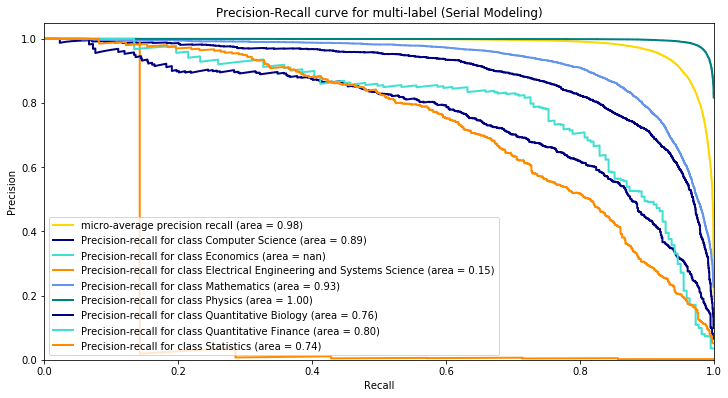

In [60]:
precision_recall_plot(prec_s, recall_s, avg_prec_s, "Precision-Recall curve for multi-label (Serial Modeling)", label_cols=list(y_val.columns), save_fig=False)

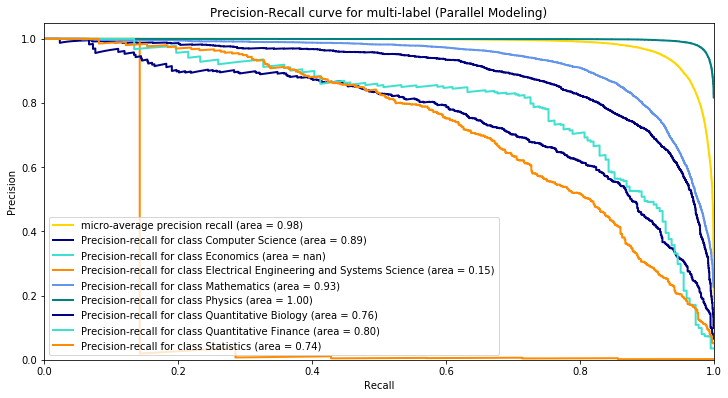

In [61]:
precision_recall_plot(prec_p, recall_p, avg_prec_p, "Precision-Recall curve for multi-label (Parallel Modeling)", label_cols=list(y_val.columns), save_fig=False)

# Hyper-parameter optimization with dask_ml GridSearchCV

In [62]:
# We are using scheduler=processes due to single machine memory limitations
cv =  GridSearchCV(NbLogisticClassifier(), param_grid={"penalty": ["l1", "l2"], "C": [1e-8, 1e-6, 1e-4, 1e-2]}, scoring="precision", refit=True, scheduler="processes")

In [63]:
cv.fit(X, y.loc[:,"Statistics"])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cache_cv=True, cv=None, error_score='raise',
       estimator=NbLogisticClassifier(C=1.0, dual=True, n_jobs=1, penalty='l2',
           random_state=42),
       iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1e-08, 1e-06, 0.0001, 0.01]},
       refit=True, return_train_score='warn', scheduler='processes',
       scoring='precision')

In [64]:
cv.best_params_

{'C': 1e-08, 'penalty': 'l1'}

In [65]:
print(f"Optimized precision: {cv.best_score_}")

Optimized precision: 0.8374991804145706
